In [0]:
import numpy as np
import matplotlib.pyplot as plt
from hyperopt import hp, fmin, Trials, tpe
from helper_functions import get_airport_data, apply_index_frequency, generate_splits,\
    HWES, HWES_optimization_function, run_hyperparameter_tuning, get_raw_airport_data_spark,\
        get_airport_data_spark, get_all_airports_spark, HWES_optimization_function_spark,\
            run_hyperparameter_tuning_cluster, run_hyperparameter_tuning_udf
from pyspark.sql import types, functions

# Introduction To HyperOpt (Tree-Structured Parzen Estimators - TPEs)

In [0]:
def objective_function(x):
    func = np.poly1d([1, -3, -88, 112, -5])
    return func(x) * 0.01

In [0]:
trials = Trials()
trial_estimator = fmin(fn = objective_function, space = hp.uniform('x', -12, 12), algo = tpe.suggest,
                       trials = trials, max_evals = 1000)

100%|██████████| 1000/1000 [00:13<00:00, 73.09trial/s, best loss: -22.17534867987629]


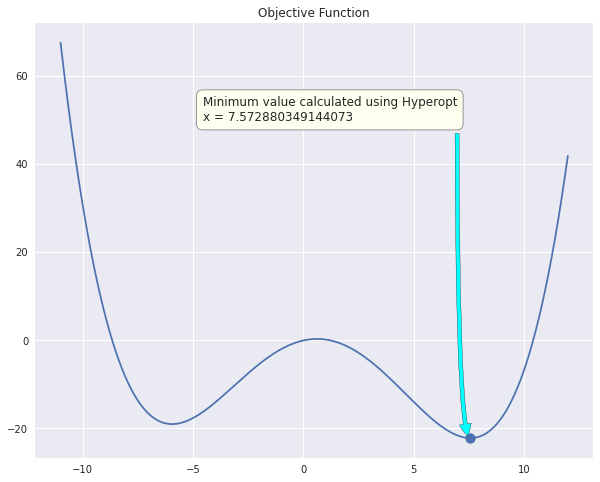

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
File <command-270567242528284>:15
      9 configuration = dict(xycoords = 'data', textcoords = 'axes fraction',
     10                       arrowprops = dict(facecolor = 'aqua', shrink = 0.01, connectionstyle = 'angle3'),
     11                       bbox = dict(boxstyle = 'round,pad=0.5', fc = 'ivory', ec = 'grey', lw = 0.8),
     12                       ha = 'left', va = 'center', fontsize = 12)
     13 ax.annotate(bbox_text, xy = (trial_estimator['x'], trials.average_best_error()),
     14             xytext = (0.3, 0.8), **configuration)
---> 15 bbox_text.get_window_extent(fig.canvas.get_renderer())
     16 fig.tight_layout()

AttributeError: 'str' object has no attribute 'get_window_extent'

In [0]:
rng = np.arange(-11.0, 12.0, 0.01)
values = [objective_function(x) for x in rng]
with plt.style.context(style = 'seaborn'):
    fig, ax = plt.subplots(1, 1, figsize = (10, 8))
    ax.plot(rng, values)
    ax.set_title('Objective Function')
    ax.scatter(x = trial_estimator['x'], y = trials.average_best_error(), marker = 'o', s = 100)
    bbox_text = 'Minimum value calculated using Hyperopt\nx = {}'.format(trial_estimator['x'])
    configuration = dict(xycoords = 'data', textcoords = 'axes fraction',
                          arrowprops = dict(facecolor = 'aqua', shrink = 0.01, connectionstyle = 'angle3'),
                          bbox = dict(boxstyle = 'round,pad=0.5', fc = 'ivory', ec = 'grey', lw = 0.8),
                          ha = 'left', va = 'center', fontsize = 12)
    ax.annotate(bbox_text, xy = (trial_estimator['x'], trials.average_best_error()),
                xytext = (0.3, 0.8), **configuration)
    bbox_text.get_window_extent(fig.canvas.get_renderer())
    fig.tight_layout()

# Apply HyperOpt To Optimize The Hyperparameters For The Time-Series Forecasting

In [0]:
hyperopt_search_space = {'model': {'trend': hp.choice('trend', ['add', 'mul']),
                                   'seasonal': hp.choice('seasonal', ['add', 'mul']),
                                   'seasonal_periods': hp.quniform('seasonal_periods', 12, 120, 12),
                                   'damped_trend': hp.choice('damped_trend', [True, False])},
                         'fit': {'smoothing_level': hp.uniform('smoothing_level', 0.01, 0.99),
                                 'smoothing_seasonal': hp.uniform('smoothing_seasonal', 0.01, 0.99),
                                 'damping_trend': hp.uniform('damping_trend', 0.01, 0.99),
                                 'use_brute': hp.choice('use_brute', [True, False]),
                                 'method': hp.choice('method', ['basinhopping', 'L-BFGS-B']),
                                 'remove_bias': hp.choice('remove_bias', [True, False])}}

In [0]:
parameters = {'optimization_function': HWES_optimization_function, 
              'tuning_space': hyperopt_search_space,
              'forecast_algo': HWES, 'loss_metric': 'BIC', 'hyperopt_algo': tpe.suggest,
              'iterations': 400, 'time_series_name': 'JFK (HyperOpt)', 'value_name': 'Total Passengers',
              'image_name': 'JFK Total Passengers (Hyperparameter Tuning Using HyperOpt).svg'}

In [0]:
JFK_airport_data = get_airport_data('JFK', '/dbfs/user/TCPD/datasets/jfk_passengers/air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv')
JFK_airport_data = apply_index_frequency(JFK_airport_data, 'MS')
JFK_training_dataset, JFK_testing_dataset = generate_splits(JFK_airport_data, '2014-12-01')
JFK_hyperopt = run_hyperparameter_tuning(JFK_training_dataset['Total Passengers'],
                                         JFK_testing_dataset['Total Passengers'], parameters)

  0%|          | 0/400 [00:00<?, ?trial/s, best loss=?]

/databricks/python/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(



  0%|          | 1/400 [00:10<1:06:44, 10.04s/trial, best loss: 325.70431630908695]

job exception: INVALID_PARAMETER_VALUE: Parameter with key fit was already logged with a value of {'damping_trend': 0.5743972193865392, 'method': 'basinhopping', 'remove_bias': False, 'smoothing_level': 0.44936255215043697, 'smoothing_seasonal': 0.9667513999286348, 'use_brute': False}. The attempted new value was {'damping_trend': 0.7121874898936623, 'method': 'basinhopping', 'remove_bias': True, 'smoothing_level': 0.6349177025612116, 'smoothing_seasonal': 0.6151421640988426, 'use_brute': False}



  0%|          | 1/400 [00:13<1:30:18, 13.58s/trial, best loss: 325.70431630908695]


---------------------------------------------------------------------------
RestException                             Traceback (most recent call last)
File <command-270567242528288>:4
      2 JFK_airport_data = apply_index_frequency(JFK_airport_data, 'MS')
      3 JFK_training_dataset, JFK_testing_dataset = generate_splits(JFK_airport_data, '2014-12-01')
----> 4 JFK_hyperopt = run_hyperparameter_tuning(JFK_training_dataset['Total Passengers'],
      5                                          JFK_testing_dataset['Total Passengers'], parameters)

File /local_disk0/spark-6c7b0ae6-fcba-41b7-ab38-ecccafef9ea1/userFiles-6653a271-1676-4753-824c-c95057aebe31/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py:346, in run_hyperparameter_tuning(train, test, params)
    344 output = {}
    345 trial_run = Trials()
--> 346 hyperparameter_tuning = fmin(fn = partial(params['optimization_function'], train = train, test = test,
    347                                           lo

# HyperOpt Using A Spark Cluster

In [0]:
csv_file_location = 'dbfs:/user/TCPD/datasets/jfk_passengers/air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv'
database_name = 'edwingoh95'
table_name = 'all_airports'
full_name = '{}.{}'.format(database_name, table_name)

In [0]:
spark.sql('CREATE DATABASE IF NOT EXISTS {};'.format(database_name))

airport_schema = types.StructType([types.StructField('Airport_Code', types.StringType()),
                                   types.StructField('Year', types.StringType()),
                                   types.StructField('Month', types.StringType()),
                                   types.StructField('Domestic_Passengers', types.IntegerType()),
                                   types.StructField('International_Passengers', types.IntegerType()),
                                   types.StructField('Total_Passengers', types.IntegerType())])

all_airport_traffic = spark.read.csv(csv_file_location, header = True, inferSchema = False,
                                    schema = airport_schema).withColumn('day', functions.lit('1'))
all_airport_traffic_formatted = all_airport_traffic.withColumn('Raw Date', functions.concat_ws(
    '-', *[functions.col('Year'), functions.col('Month'), functions.col('Day')])).withColumn(
        'Date', functions.to_date(functions.col('Raw Date'), format = 'yyyy-MMM-d')).drop(
            *['Year', 'Month', 'Day', 'Raw Date'])
all_airport_traffic_formatted.write.format('delta').mode('overwrite').option(
    'mergeSchema', 'true').option('overwriteSchema', 'true').partitionBy(
        'Airport_Code').saveAsTable(full_name)

In [0]:
output_schema = types.StructType([
    types.StructField('Airport', types.StringType()), types.StructField('Date', types.DateType()),
    types.StructField('Total_Passengers_Forecast', types.IntegerType()),
    types.StructField('Is_Future', types.BooleanType())])

In [0]:
@functions.pandas_udf(output_schema, functions.PandasUDFType.GROUPED_MAP)
def airport_forecast(airport):
    airport_data = get_airport_data_spark(spark, full_name)
    airport_name = airport_data['Airport_Code'][0]
    spark_run_parameters = {'optimization_function': HWES_optimization_function_spark,
                            'tuning_space': hyperopt_search_space, 'forecast_algo': HWES,
                            'loss_metric': 'BIC', 'hyperopt_algo': tpe.suggest,
                            'timeout': 1800, 'iterations': 600, 'experiment_name': 'Airport_Forecast',
                            'time_series_name': '{} (HyperOpt)'.format(airport_name),
                            'value_name': 'Total Passengers',
                            'image_name': '{} Total Passengers (Hyperparameter Tuning Using HyperOpt).svg'
                            .format(airport_name)}
    airport_data = apply_index_frequency(airport_data, 'MS').fillna(
        method = 'ffill').fillna(method = 'bfill')
    airport_training_dataset, airport_testing_dataset = generate_splits(airport_data, '2014-12-01')
    airport_hyperopt = run_hyperparameter_tuning_udf(airport_training_dataset['Total_Passengers'],
                                                     airport_testing_dataset['Total_Passengers'],spark_run_parameters)
    return airport_hyperopt

In [0]:
def validate_data_counts(data, split_count):
    return list(data.groupBy(
        functions.col('Airport_Code')).count().withColumn('check', functions.when(
            ((functions.lit(12)/0.2) < (functions.col('count') * 0.8)), 
            True).otherwise(False)).filter(functions.col('check')).select(
                'Airport_Code').toPandas()['Airport_Code'])

In [0]:
airport_traffic_dataset = spark.table(full_name)
filtered_dataset = airport_traffic_dataset.where(functions.col('Airport_Code').isin(
    validate_data_counts(airport_traffic_dataset, 12))).repartition('Airport_Code')

In [0]:
airports = [str(airport[0]) for airport in filtered_dataset.select('Airport_Code').distinct().collect()]

## Distributed Hyperopt Using SparkTrials

Importing data for EWR...
Running Hyperopt for EWR...


Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.


 37%|███▋      | 374/1000 [12:52<16:14,  1.56s/tr

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████| 1000/1000 [25:58<00:00,  1.56s/trial, best loss: 280.09316243431255]


Total Trials: 1000: 1000 succeeded, 0 failed, 0 cancelled.


Best hyperparameters for EWR: {'fit': {'damping_trend': 0.9886395531301903, 'method': 'L-BFGS-B', 'remove_bias': True, 'smoothing_level': 0.13069629613005496, 'smoothing_seasonal': 0.5282129614479886, 'use_brute': True}, 'model': {'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 48.0, 'trend': 'mul'}}
Importing data for JFK...
Running Hyperopt for JFK...


Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.


 35%|███▍      | 346/1000 [19:04<25:50,  2.37s/trial, best loss: 308.5932131043241]

trial task 347 failed, exception is Input contains NaN, infinity or a value too large for dtype('float64')..
 Traceback (most recent call last):
  File "/databricks/.python_edge_libs/hyperopt/spark.py", line 629, in run_task_on_executor
    result = domain.evaluate(
  File "/databricks/.python_edge_libs/hyperopt/base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
  File "/local_disk0/spark-07488705-ebca-4a37-b0ce-926d8aa58494/executor-6af85b5a-63da-4052-9622-fe9b51a038c9/spark-83df6937-7c4b-43e2-bd4d-077372d6bed8/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 324, in HWES_optimization_function
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_HWES(hp_values))
  File "/local_disk0/spark-07488705-ebca-4a37-b0ce-926d8aa58494/executor-6af85b5a-63da-4052-9622-fe9b51a038c9/spark-83df6937-7c4b-43e2-bd4d-077372d6bed8/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 246, in calculate_error

 53%|█████▎    | 530/1000 [30:07<27:43,  3.54s/trial, best loss: 306.6024057406895]

trial task 533 failed, exception is Input contains NaN, infinity or a value too large for dtype('float64')..
 Traceback (most recent call last):
  File "/databricks/.python_edge_libs/hyperopt/spark.py", line 629, in run_task_on_executor
    result = domain.evaluate(
  File "/databricks/.python_edge_libs/hyperopt/base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
  File "/local_disk0/spark-df4ed14c-5f0c-46c5-97b7-30fe4226fb05/executor-fce9b245-c02d-4460-9246-c9f52febf008/spark-3137f765-c91d-496c-b8f9-7c8b226b2643/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 324, in HWES_optimization_function
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_HWES(hp_values))
  File "/local_disk0/spark-df4ed14c-5f0c-46c5-97b7-30fe4226fb05/executor-fce9b245-c02d-4460-9246-c9f52febf008/spark-3137f765-c91d-496c-b8f9-7c8b226b2643/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 246, in calculate_error

100%|█████████▉| 998/1000 [55:00<00:06,  3.31s/trial, best loss: 306.10838296268855]


Total Trials: 1000: 998 succeeded, 2 failed, 0 cancelled.
To get error messages for failed trail runs, fully expand "Spark Jobs" above, and click the (i) icon beside a stage with skips to open the Spark UI. Then go to the "Tasks" section, and click "stderr" to open executor logs.


Best hyperparameters for JFK: {'fit': {'damping_trend': 0.4919104845250982, 'method': 'basinhopping', 'remove_bias': True, 'smoothing_level': 0.6088344858278348, 'smoothing_seasonal': 0.43602993600480144, 'use_brute': True}, 'model': {'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 48.0, 'trend': 'mul'}}
Importing data for LGA...
Running Hyperopt for LGA...


Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.


 74%|███████▍  | 742/1000 [20:13<06:06,  1.42s/trial, best loss: 287.79786961643674]

trial task 736 failed, exception is Input contains NaN, infinity or a value too large for dtype('float64')..
 Traceback (most recent call last):
  File "/databricks/.python_edge_libs/hyperopt/spark.py", line 629, in run_task_on_executor
    result = domain.evaluate(
  File "/databricks/.python_edge_libs/hyperopt/base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
  File "/local_disk0/spark-07488705-ebca-4a37-b0ce-926d8aa58494/executor-6af85b5a-63da-4052-9622-fe9b51a038c9/spark-83df6937-7c4b-43e2-bd4d-077372d6bed8/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 324, in HWES_optimization_function
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_HWES(hp_values))
  File "/local_disk0/spark-07488705-ebca-4a37-b0ce-926d8aa58494/executor-6af85b5a-63da-4052-9622-fe9b51a038c9/spark-83df6937-7c4b-43e2-bd4d-077372d6bed8/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 246, in calculate_error

100%|█████████▉| 999/1000 [26:27<00:01,  1.59s/trial, best loss: 287.01655366639454]


Total Trials: 1000: 999 succeeded, 1 failed, 0 cancelled.
To get error messages for failed trail runs, fully expand "Spark Jobs" above, and click the (i) icon beside a stage with skips to open the Spark UI. Then go to the "Tasks" section, and click "stderr" to open executor logs.


Best hyperparameters for LGA: {'fit': {'damping_trend': 0.4765082196043121, 'method': 'L-BFGS-B', 'remove_bias': True, 'smoothing_level': 0.5437468126761479, 'smoothing_seasonal': 0.7534304468498829, 'use_brute': True}, 'model': {'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 24.0, 'trend': 'add'}}
Importing data for SWF...
Running Hyperopt for SWF...


Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.


  1%|          | 6/1000 [00:25<58:04,  3.51s/trial, best loss: 233.13906256656077]

trial task 10 failed, exception is Input contains NaN, infinity or a value too large for dtype('float64')..
 Traceback (most recent call last):
  File "/databricks/.python_edge_libs/hyperopt/spark.py", line 629, in run_task_on_executor
    result = domain.evaluate(
  File "/databricks/.python_edge_libs/hyperopt/base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
  File "/local_disk0/spark-07488705-ebca-4a37-b0ce-926d8aa58494/executor-6af85b5a-63da-4052-9622-fe9b51a038c9/spark-83df6937-7c4b-43e2-bd4d-077372d6bed8/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 324, in HWES_optimization_function
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_HWES(hp_values))
  File "/local_disk0/spark-07488705-ebca-4a37-b0ce-926d8aa58494/executor-6af85b5a-63da-4052-9622-fe9b51a038c9/spark-83df6937-7c4b-43e2-bd4d-077372d6bed8/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 246, in calculate_errors

  3%|▎         | 33/1000 [01:33<56:04,  3.48s/trial, best loss: 199.19108536291407]

trial task 37 failed, exception is Input contains NaN, infinity or a value too large for dtype('float64')..
 Traceback (most recent call last):
  File "/databricks/.python_edge_libs/hyperopt/spark.py", line 629, in run_task_on_executor
    result = domain.evaluate(
  File "/databricks/.python_edge_libs/hyperopt/base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
  File "/local_disk0/spark-df4ed14c-5f0c-46c5-97b7-30fe4226fb05/executor-fce9b245-c02d-4460-9246-c9f52febf008/spark-3137f765-c91d-496c-b8f9-7c8b226b2643/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 324, in HWES_optimization_function
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_HWES(hp_values))
  File "/local_disk0/spark-df4ed14c-5f0c-46c5-97b7-30fe4226fb05/executor-fce9b245-c02d-4460-9246-c9f52febf008/spark-3137f765-c91d-496c-b8f9-7c8b226b2643/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 246, in calculate_errors

  4%|▍         | 45/1000 [02:03<28:43,  1.81s/trial, best loss: 199.19108536291407]

trial task 51 failed, exception is Input contains NaN, infinity or a value too large for dtype('float64')..
 Traceback (most recent call last):
  File "/databricks/.python_edge_libs/hyperopt/spark.py", line 629, in run_task_on_executor
    result = domain.evaluate(
  File "/databricks/.python_edge_libs/hyperopt/base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
  File "/local_disk0/spark-07488705-ebca-4a37-b0ce-926d8aa58494/executor-6af85b5a-63da-4052-9622-fe9b51a038c9/spark-83df6937-7c4b-43e2-bd4d-077372d6bed8/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 324, in HWES_optimization_function
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_HWES(hp_values))
  File "/local_disk0/spark-07488705-ebca-4a37-b0ce-926d8aa58494/executor-6af85b5a-63da-4052-9622-fe9b51a038c9/spark-83df6937-7c4b-43e2-bd4d-077372d6bed8/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 246, in calculate_errors

 12%|█▏        | 120/1000 [06:05<33:17,  2.27s/trial, best loss: 199.19108536291407]

trial task 126 failed, exception is Input contains NaN, infinity or a value too large for dtype('float64')..
 Traceback (most recent call last):
  File "/databricks/.python_edge_libs/hyperopt/spark.py", line 629, in run_task_on_executor
    result = domain.evaluate(
  File "/databricks/.python_edge_libs/hyperopt/base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
  File "/local_disk0/spark-df4ed14c-5f0c-46c5-97b7-30fe4226fb05/executor-fce9b245-c02d-4460-9246-c9f52febf008/spark-3137f765-c91d-496c-b8f9-7c8b226b2643/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 324, in HWES_optimization_function
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_HWES(hp_values))
  File "/local_disk0/spark-df4ed14c-5f0c-46c5-97b7-30fe4226fb05/executor-fce9b245-c02d-4460-9246-c9f52febf008/spark-3137f765-c91d-496c-b8f9-7c8b226b2643/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 246, in calculate_error

 45%|████▌     | 451/1000 [18:50<24:21,  2.66s/trial, best loss: 192.17089202034236]

trial task 458 failed, exception is Input contains NaN, infinity or a value too large for dtype('float64')..
 Traceback (most recent call last):
  File "/databricks/.python_edge_libs/hyperopt/spark.py", line 629, in run_task_on_executor
    result = domain.evaluate(
  File "/databricks/.python_edge_libs/hyperopt/base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
  File "/local_disk0/spark-08103ec4-a5ab-4464-bea6-161758d6159d/executor-9ab08ff6-aca2-4740-98a1-1e885e011cd3/spark-0118ccbd-5c97-4f87-9988-70c5dba21acb/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 324, in HWES_optimization_function
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_HWES(hp_values))
  File "/local_disk0/spark-08103ec4-a5ab-4464-bea6-161758d6159d/executor-9ab08ff6-aca2-4740-98a1-1e885e011cd3/spark-0118ccbd-5c97-4f87-9988-70c5dba21acb/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 246, in calculate_error

 46%|████▌     | 458/1000 [19:12<25:29,  2.82s/trial, best loss: 192.17089202034236]

trial task 466 failed, exception is Input contains NaN, infinity or a value too large for dtype('float64')..
 Traceback (most recent call last):
  File "/databricks/.python_edge_libs/hyperopt/spark.py", line 629, in run_task_on_executor
    result = domain.evaluate(
  File "/databricks/.python_edge_libs/hyperopt/base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
  File "/local_disk0/spark-df4ed14c-5f0c-46c5-97b7-30fe4226fb05/executor-fce9b245-c02d-4460-9246-c9f52febf008/spark-3137f765-c91d-496c-b8f9-7c8b226b2643/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 324, in HWES_optimization_function
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_HWES(hp_values))
  File "/local_disk0/spark-df4ed14c-5f0c-46c5-97b7-30fe4226fb05/executor-fce9b245-c02d-4460-9246-c9f52febf008/spark-3137f765-c91d-496c-b8f9-7c8b226b2643/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 246, in calculate_error

 50%|█████     | 500/1000 [20:43<16:35,  1.99s/trial, best loss: 192.17089202034236]

trial task 507 failed, exception is Input contains NaN, infinity or a value too large for dtype('float64')..
 Traceback (most recent call last):
  File "/databricks/.python_edge_libs/hyperopt/spark.py", line 629, in run_task_on_executor
    result = domain.evaluate(
  File "/databricks/.python_edge_libs/hyperopt/base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
  File "/local_disk0/spark-df4ed14c-5f0c-46c5-97b7-30fe4226fb05/executor-fce9b245-c02d-4460-9246-c9f52febf008/spark-3137f765-c91d-496c-b8f9-7c8b226b2643/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 324, in HWES_optimization_function
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_HWES(hp_values))
  File "/local_disk0/spark-df4ed14c-5f0c-46c5-97b7-30fe4226fb05/executor-fce9b245-c02d-4460-9246-c9f52febf008/spark-3137f765-c91d-496c-b8f9-7c8b226b2643/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 246, in calculate_error

 57%|█████▋    | 570/1000 [22:46<13:17,  1.85s/trial, best loss: 192.17089202034236]

trial task 577 failed, exception is Input contains NaN, infinity or a value too large for dtype('float64')..
 Traceback (most recent call last):
  File "/databricks/.python_edge_libs/hyperopt/spark.py", line 629, in run_task_on_executor
    result = domain.evaluate(
  File "/databricks/.python_edge_libs/hyperopt/base.py", line 892, in evaluate
    rval = self.fn(pyll_rval)
  File "/local_disk0/spark-07488705-ebca-4a37-b0ce-926d8aa58494/executor-6af85b5a-63da-4052-9622-fe9b51a038c9/spark-83df6937-7c4b-43e2-bd4d-077372d6bed8/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 324, in HWES_optimization_function
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_HWES(hp_values))
  File "/local_disk0/spark-07488705-ebca-4a37-b0ce-926d8aa58494/executor-6af85b5a-63da-4052-9622-fe9b51a038c9/spark-83df6937-7c4b-43e2-bd4d-077372d6bed8/addedFile3237362703925507348helper_functions.zip.jar/helper_functions.py", line 246, in calculate_error

 99%|█████████▉| 992/1000 [38:44<00:18,  2.34s/trial, best loss: 192.12531016167355]


Total Trials: 1000: 992 succeeded, 8 failed, 0 cancelled.
To get error messages for failed trail runs, fully expand "Spark Jobs" above, and click the (i) icon beside a stage with skips to open the Spark UI. Then go to the "Tasks" section, and click "stderr" to open executor logs.
/databricks/python/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Best hyperparameters for SWF: {'fit': {'damping_trend': 0.23007915289147562, 'method': 'basinhopping', 'remove_bias': False, 'smoothing_level': 0.35928142256325607, 'smoothing_seasonal': 0.5765095786340846, 'use_brute': False}, 'model': {'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 12.0, 'trend': 'mul'}}


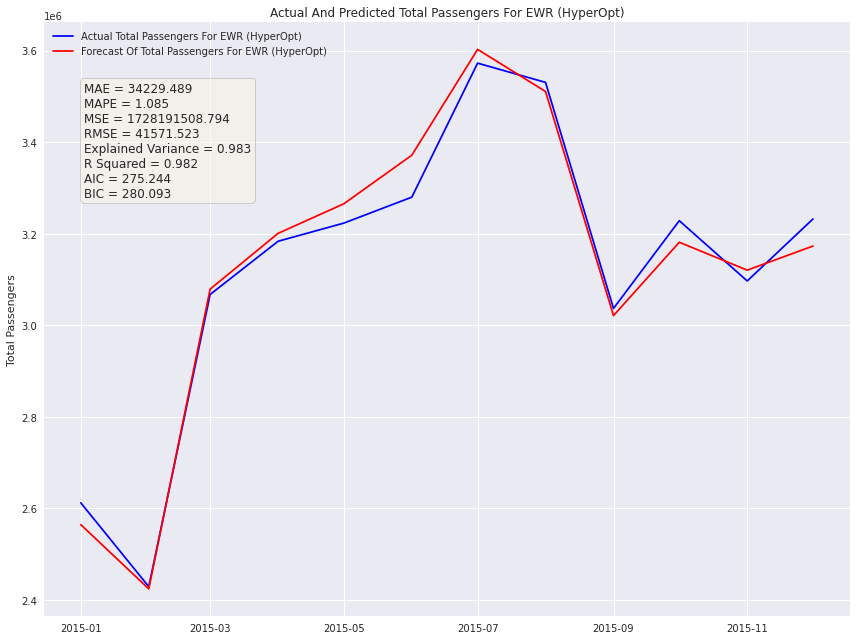

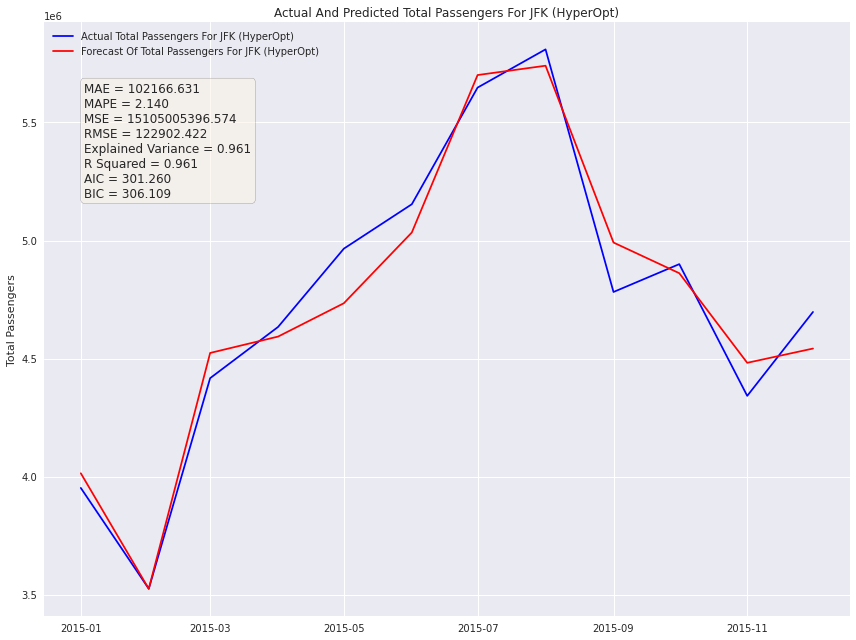

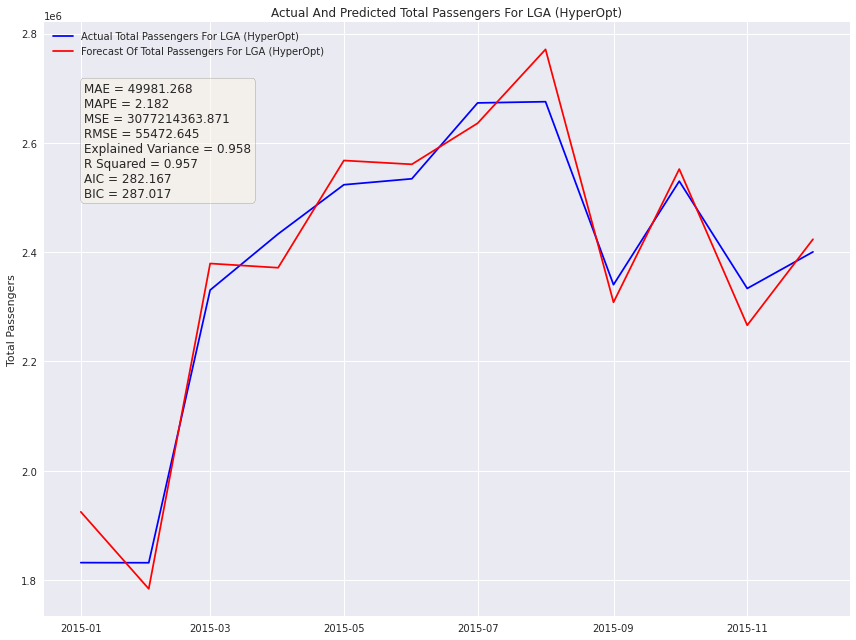

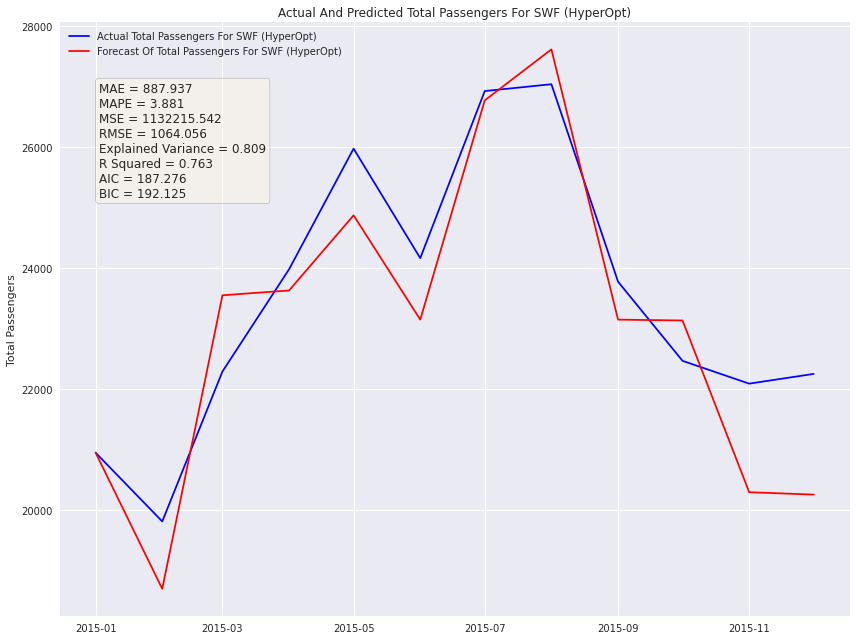

In [0]:
best_hyperparameters = {}
for airport_name in airports:
    spark_run_parameters = {'optimization_function': HWES_optimization_function,
                            'tuning_space': hyperopt_search_space, 'forecast_algo': HWES,
                            'loss_metric': 'BIC', 'hyperopt_algo': tpe.suggest, 'parallelism': 64,
                            'timeout': 3600, 'iterations': 1000, 'airport_name': airport_name,
                            'experiment_name': 'Airport_Forecast', 
                            'time_series_name': '{} (HyperOpt)'.format(airport_name),
                            'value_name': 'Total Passengers',
                            'image_name': '{} Total Passengers (Hyperparameter Tuning Using HyperOpt).png'.format(airport_name),
                            'hyperopt_image_name': '{} Total Passengers (Hyperparameter Tuning Using HyperOpt).png'.format(airport_name)}
    print('Importing data for {}...'.format(airport_name))
    airport_data = get_airport_data_spark(spark, airport_name, full_name)
    airport_data = apply_index_frequency(airport_data, 'MS').fillna(
        method = 'ffill').fillna(method = 'bfill')
    training_dataset, test_dataset = generate_splits(airport_data, '2014-12-01')
    print('Running Hyperopt for {}...'.format(airport_name))
    airport_hyperopt = run_hyperparameter_tuning_cluster(training_dataset['Total_Passengers'],
                                                         test_dataset['Total_Passengers'], spark_run_parameters)
    print('Best hyperparameters for {}: {}'.format(airport_name, airport_hyperopt['best_hyperparameters']))
    best_hyperparameters[airport_name] = airport_hyperopt['best_hyperparameters']

In [0]:
import json 

print(json.dumps(best_hyperparameters, indent = 4))

{
    "EWR": {
        "fit": {
            "damping_trend": 0.9886395531301903,
            "method": "L-BFGS-B",
            "remove_bias": true,
            "smoothing_level": 0.13069629613005496,
            "smoothing_seasonal": 0.5282129614479886,
            "use_brute": true
        },
        "model": {
            "damped_trend": false,
            "seasonal": "add",
            "seasonal_periods": 48.0,
            "trend": "mul"
        }
    },
    "JFK": {
        "fit": {
            "damping_trend": 0.4919104845250982,
            "method": "basinhopping",
            "remove_bias": true,
            "smoothing_level": 0.6088344858278348,
            "smoothing_seasonal": 0.43602993600480144,
            "use_brute": true
        },
        "model": {
            "damped_trend": true,
            "seasonal": "mul",
            "seasonal_periods": 48.0,
            "trend": "mul"
        }
    },
    "LGA": {
        "fit": {
            "damping_trend": 0.47650821960431

## Distributed Hyperopt Using Pandas User Defined Functions (pandas_udf)

In [0]:
grouped_apply = filtered_dataset.groupBy('Airport_Code').apply(airport_forecast)
grouped_apply.show(grouped_apply.count(), False)

# Artifact Management 

## MLflow's Model Registry

In [0]:
import mlflow
mlflow.set_registry_uri('databricks-uc') 
import pandas as pd
from datetime import datetime
from dataclasses import dataclass
from mlflow.tracking.client import MlflowClient

/databricks/python_shell/dbruntime/MlflowPatches.py:293: UserWarning: Registering and loading models to and from Unity Catalog is unsupported in the current MLflow client version. Please upgrade to MLflow 2.4.1 or above to access models in the Unity Catalog. You can do this by running %pip install --upgrade 'mlflow-skinny[databricks]' in a notebook cell.
  warnings.warn(


In [0]:
@dataclass
class Registry:
    model_name: str
    production_version: int
    updated: bool
    training_time: str()

In [0]:
class RegistryStructure:
    def __init__(self, data):
        self.data = data

    def generate_row(self):
        spark_df = spark.createDataFrame(pd.DataFrame([vars(self.data)]))
        return spark_df.withColumn(
            'training_time', functions.to_timestamp(functions.col('training_time'))).withColumn(
                'production_version', functions.col('production_version').cast('long'))

In [0]:
class RegistryLogging:
    def __init__(self, database, table, delta_location, model_name, production_version, updated):
        self.database = database
        self.table = table
        self.delta_location = delta_location
        self.entry_data = Registry(model_name, production_version, updated, self._get_time())

    @classmethod
    def _get_time(self):
        return datetime.today().strftime('%Y-%m-%d %H:%M:%S')

    def _check_exists(self):
        return spark._jsparkSession.catalog().tableExists(self.database, self.table)

    def write_entry(self):
        log_row = RegistryStructure(self.entry_data).generate_row()
        log_row.write.format('delta').mode('append').save(self.delta_location)
        if not self._check_exists():
            spark.sql("CREATE TABLE IF NOT EXISTS {}.{} USING DELTA LOCATION '{}';".format(
                self.database, self.table, self.delta_location))

In [0]:
class ModelRegistration:
    def __init__(self, experiment_name, experiment_title, model_name, metric, direction):
        self.experiment_name = experiment_name
        self.experiment_title = experiment_title
        self.model_name = model_name
        self.metric = metric
        self.direction = direction
        self.client = MlflowClient()
        self.experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

    def _get_best_run_info(self, key):
        run_data = mlflow.search_runs(model_registry.experiment_id, 
                                      filter_string = "tags.mlflow.runName LIKE 'PARENT_RUN_%'", 
                                      order_by = ['metrics.{} {}'.format(self.metric, self.direction)])
        return run_data.head(1)[key].values[0]

    def _get_registered_status(self):
        return self.client.get_registered_model(name = self.experiment_title)

    def _get_current_production(self):
        return [x.run_id for x in self._get_registered_status().latest_versions
                if x.current_stage == 'Production'][0]

    def _get_production_version(self):
        return int([x.version for x in self._get_registered_status().latest_versions
                    if x.current_stage == 'Production'][0])

    def _get_metric(self, run_id):
        return mlflow.get_run(run_id).data.metrics.get(self.metric)

    def _find_best_model(self):
        try:
            current_production_id = self._get_current_production()
            production_metric = self._get_metric(current_production_id)
        except mlflow.exceptions.MlflowException:
            current_production_id = -1
            production_metric = 1e9
        best_run_id = self._get_best_run_info('run_id')
        best_metric = self._get_metric(best_run_id)
        if self.direction == 'ASC':
            if production_metric < best_metric:
                return current_production_id
            else:
                return best_run_id
        else:
            if production_metric > best_metric:
                return current_production_id
            else:
                return best_run_id

    def _generate_artifact_path(self, run_id):
        return 'runs:/{}/{}'.format(run_id, self.model_name)

    def register_best_model(self, registration_message, logging_location, log_db, log_table):
        best_run_id = self._find_best_model()
        try:
            current_production = self._get_current_production()
            current_production_version = self._get_production_version()
        except mlflow.exceptions.MlflowException:
            current_production = -1
            current_production_version = -1
        updated = current_production != best_run_id
        if updated:
            register_new_model = mlflow.register_model(model_uri = self._generate_artifact_path(best_run_id),
                                                       name = self.experiment_title)
            self.client.update_registered_model(
                name = register_new_model.name, description = 'Total Passengers Forecast For 2015 Over Multiple Airports In NY')
            self.client.update_model_version(
                name = register_new_model.name, version = register_new_model.version,
                description = registration_message)
            self.client.transition_model_version_stage(
                name = register_new_model.name, version = register_new_model.version, stage = 'Production')
            if current_production_version > 0:
                self.client.transition_model_version_stage(
                    name = register_new_model.name, version = current_production_version, stage = 'Archived')
                RegistryLogging(log_db, log_table, logging_location, self.experiment_title, 
                                int(register_new_model.version), updated).write_entry()
                return 'Upgraded To Production'
        else:
            RegistryLogging(log_db, log_table, logging_location, self.experiment_title, 
                            int(current_production_version), updated).write_entry()
            return 'No Change'

    def get_model_as_udf(self):
        production_id = self._get_current_production()
        artifact_uri = self._generate_artifact_path(production_id)
        return mlflow.pyfunc.spark_udf(spark, model_uri = artifact_uri)

In [0]:
base_directory = '/Users/edwin.goh95@gmail.com/'
folder = 'Machine Learning Engineering In Action/'
logging_location = base_directory + folder + table_name + '_logs'

In [0]:
model_registry = ModelRegistration(
    experiment_name = base_directory + folder + 'Total Passenger Forecasts For Multiple Airports',
    experiment_title = 'Total Passengers Airport Forecasts',
    model_name = 'Holt-Winters-Exponential-Smoothing', metric = 'best_trial_loss', direction = 'ASC')
model_registry.register_best_model('Initial run', logging_location = logging_location, log_db = database_name, 
                                   log_table = 'registry_status')

Out[35]: 'No Change'